In [1]:
using PyPlot
using DataFrames
using ProgressMeter

INFO: Loading help data...


In [2]:
actions = [:north, :south, :east, :west];

type Maze_t
    maze::Matrix{Char}
    sensor_states::Vector{ASCIIString}
    Vw::Matrix{Float64}
    Qw::Array{Float64,3}
    Qs::Matrix{Float64}
    n::Matrix{Float64}
    C::Matrix{Float64}
    numbers::Matrix{Int64}
    state_reward_function::Dict{Char, Float64}
    belief::Vector{Float64}
end

### Initialisation function

In [3]:
function get_action_index(symbol::Symbol)
    r = findin(actions, [symbol])
    if length(r) != 1
        return -1
        end
    return r[1]
end

function get_sensor_state(maze::Matrix{Char}, i::Int64, j::Int64)
    foldl(string,[maze[i,j], maze[i-1,j+1], maze[i-1,j+1], maze[i, j+1], maze[i+1, j+1], maze[i+1, j], maze[i+1, j-1], maze[i,j-1], maze[i-1,j-1]])
end

function get_unique_sensor_states(maze::Matrix{Char})
    sensor_states = []
    for i=2:size(maze)[1] - 1
        for j=2:size(maze)[2] - 1
            if maze[i,j] != '#'
                sensor_state = get_sensor_state(maze, i, j)
                if sensor_state in sensor_states == false
                    sensor_states = [sensor_states, sensor_state]
                end
            end
        end
    end
    sensor_states
end

function get_sensor_index(maze::Matrix{Char}, i::Int64, j::Int64, sensor_states::Vector{ASCIIString})
    sensor_state = get_sensor_state(maze, i, j)
    lst = findin(sensor_states, [sensor_state])
    if length(lst) >= 1 && lst[1] > 0
        return lst[1]
    else
        return -1
    end
end

function get_state_coordinate(maze::Matrix{Char}, char::Char)
    for i=1:size(maze)[1]
        for j = 1:size(maze)[2]
            if maze[i,j] == char
                return i,j
            end
        end
    end
    return -1, -1
end

function convert_string_to_string_array(s::String)
    index = 1
    while s[index] == ' ' || s[index] == '\n'
        index = index + 1
    end
    maze = nothing
    row = []
    for i=index:length(s)
        if s[i] == '\n'
            if maze == nothing
                maze = row
            else
                maze = hcat(maze, row)
            end
            row = []
        else
            row = [row, s[i]]
        end
    end
    return maze'
end

function create_experiment_setup(definition::String, state_reward_function::Dict{Char,Float64})
    maze          = convert_string_to_string_array(maze_definition)
    sensor_states = get_unique_sensor_states(maze)
    Vw            = zeros(size(maze))
    Qw            = zeros(size(maze)[1], size(maze)[2], 4)
    Qs            = zeros(length(sensor_states),4)
    n             = zeros(size(maze))
    C             = zeros(size(maze))
    numbered_maze = int64(zeros(size(maze)))
    belief        = zeros(length(sensor_states))
    for i = 2:size(maze)[1]-1
        for j = 2:size(maze)[2]-1
            index = get_sensor_index(maze, i, j, sensor_states)
            if index > 0
                belief[index] = belief[index] + 1.0
                numbered_maze[i,j] = index
            end
        end
    end
    belief = [1.0/v for v in belief]
    return Maze_t(maze, sensor_states, Vw, Qw, Qs, n, C, numbered_maze, state_reward_function, belief)
end

create_experiment_setup (generic function with 1 method)

### Plot functions

In [16]:
function plot_data(maze::Maze_t)
    s = (size(maze.maze)[2], size(maze.maze)[1] .* 0.3)
    clf()
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    colorbar(imshow(maze.Qs, interpolation="none"))
    title("Q(s,a)")
    
    subplot(122)
    colorbar(imshow(maze.Vw, interpolation="none"))
    xticks([])
    yticks([])
    clim([0,1000]) # 1000 is the maximum = V('T')
    title("V(w)")
end

function write_plot_data(maze::Maze_t, filename::String)
    s = (size(maze.maze)[2], size(maze.maze)[1] .* 0.3)
    clf()
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    colorbar(imshow(maze.Qs, interpolation="none"))
    title("Q(s,a)")
    
    subplot(122)
    colorbar(imshow(maze.Vw, interpolation="none"))
    xticks([])
    yticks([])
    title("V(w)")
    clim([0,1000]) # 1000 is the maximum = V('T')    
    savefig(filename)
end

write_plot_data (generic function with 1 method)

### Policy Iteration

In [15]:
function policy_iteration!(maze::Maze_t, k::Int64)
    # Q(w,a) = \sum_{w'} p(w'|a) V(w'), where p(w'|a) is a Dirac measure
    for i = 2:size(maze.Vw)[1]-1
        for j = 2:size(maze.Vw)[2] - 1
            maze.Qw[i,j,1] = maze.Vw[i-1, j]
            maze.Qw[i,j,2] = maze.Vw[i+1, j]
            maze.Qw[i,j,3] = maze.Vw[i,   j+1]
            maze.Qw[i,j,4] = maze.Vw[i,   j-1]
        end
    end
    
    for s = 1:length(maze.sensor_states)
        for a = 1:4
            maze.Qs[s,a] = 0.0
        end
    end
    
    for i = 2:size(maze.maze)[1] - 1
        for j = 2:size(maze.maze)[2] - 1
            index = get_sensor_index(maze.maze, i, j, maze.sensor_states)
            if index > 0
                for a = 1:4
                    maze.Qs[index, a] = maze.Qs[index, a] + maze.belief[index] * maze.Qw[i,j,a]
                end
            end
        end
    end
    
    for s = 1:length(maze.sensor_states)
        values = DataFrame(VALUES=[v for v in maze.Qs[s,:]], ACTION=actions[1:4], INDICES=[1:4])
        sort!(values, cols = (:VALUES), rev=true)
        if sum(abs(values[:,1])) < 0.001 # randomise action if no values have been aquired so far
            r = randperm(4)
            values[:ACTION]=actions[r]
            values[:INDICES] = r
        end
        values = values[1:minimum([k, size(values)[1]]),:]

        v = values[:,1]
        if sum(v) < 0.1
            v = [1.0/float64(length(v)) for x=1:length(v)]
        else
            rw = sum(v)
            v  = [w / rw for w in v]
        end
        values[:,1] = v
        
        for a = 1:4
            maze.Qs[s,a] = 0.0
        end
        
        for a = 1:size(values)[1]
            maze.Qs[s,values[a,3]] = values[a,1]
        end
    end
   # plot_data(maze, "after policy iteration")
end

policy_iteration! (generic function with 1 method)

### Policy evaluation

In [6]:
function policy_evaluation!(maze::Maze_t, T::Int64, R::Int64)
    for i = 1:R
        # randomise start position
        x = 1 + int64(ceil(rand() * size(maze.maze)[1])) - 1
        y = 1 + int64(ceil(rand() * size(maze.maze)[2])) - 1
    
        while maze.maze[x,y] == '#'
            x = 1 + int64(ceil(rand() * size(maze.maze)[1])) - 1
            y = 1 + int64(ceil(rand() * size(maze.maze)[2])) - 1
        end
    
        init_x = x
        init_y = y
        
        if maze.maze[init_x,init_y] in keys(maze.state_reward_function)
            # we are done, if we are on a reward field
            maze.Vw[init_x,init_y] = maze.state_reward_function[maze.maze[init_x,init_y]]
            break
        end

        for i=1:T
            s = get_sensor_index(maze.maze, x, y, maze.sensor_states)
            probabilities = maze.Qs[s,:]
            p = rand()            
            action = actions[end]
            for j = 1:4
                if p < sum(probabilities[1:j])
                    action = actions[j]
                    break
                end
            end

            if action == :north
                if maze.maze[x - 1,y] == 'B'
                    maze.C[init_x, init_y] = maze.C[init_x, init_y] - 1.0
                    x, y = get_state_coordinate(maze.maze, 'S')
                elseif maze.maze[x - 1,y] != '#'
                    maze.C[init_x, init_y] = maze.C[init_x, init_y] - 1.0
                    x = x - 1
                end
            elseif action == :south
                if maze.maze[x + 1,y] == 'B'
                    maze.C[init_x, init_y] = maze.C[init_x, init_y] - 1.0
                    x, y = get_state_coordinate(maze.maze, 'S')
                elseif maze.maze[x + 1,y] != '#'
                    maze.C[init_x, init_y] = maze.C[init_x, init_y] - 1.0
                    x = x + 1
                end
            elseif action == :east
                if maze.maze[x,y + 1] == 'B'
                    maze.C[init_x, init_y] = maze.C[init_x, init_y] - 1.0
                    x, y = get_state_coordinate(maze.maze, 'S')
                elseif maze.maze[x,y + 1] != '#'
                    maze.C[init_x, init_y] = maze.C[init_x, init_y] - 1.0
                    y = y + 1
                end
            elseif action == :west
                if maze.maze[x,y - 1] == 'B'
                    maze.C[init_x, init_y] = maze.C[init_x, init_y] - 1.0
                    x, y = get_state_coordinate(maze.maze, 'S')
                elseif maze.maze[x,y - 1] != '#'
                    maze.C[init_x, init_y] = maze.C[init_x, init_y] - 1.0
                    y = y - 1
                end
            end
            if maze.maze[x,y] in keys(maze.state_reward_function)
                maze.C[init_x, init_y] = maze.C[init_x, init_y] + maze.state_reward_function[maze.maze[x,y]]
                break # done. we found a reward
            end
        end
        maze.n[init_x, init_y]  = maze.n[init_x, init_y] + 1.0
        maze.Vw[init_x, init_y] = maze.C[init_x, init_y] / maze.n[init_x, init_y]
    end
   # plot_data(maze, "after policy evaluation\n")
end

policy_evaluation! (generic function with 1 method)

### Evaluation

In [34]:
maze_definition = "
#########
###T   B#
##### ###
#B    ###
### #####
###S#####
#########
"

function run_experiment(k::Int64, trials::Int64, epoch_length::Int64, T::Int64, N::Int64)
    pm = Progress(trials * epoch_length, 1)
    values = zeros(epoch_length)
    mazes = []
    for i = 1:trials
        maze = create_experiment_setup(maze_definition, ['T' => 1000.0])
        mazes = [mazes, maze]
        v = zeros(epoch_length)
        x,y = get_state_coordinate(maze.maze, 'S')
       
        for j = 1:epoch_length
            policy_evaluation!(maze, N, T)
            policy_iteration!(maze, k)
            v[j] = maze.Vw[x,y]
            next!(pm)
        end
        values = values .+ v
    end
    return mazes, (values ./ float64(trials))
end

run_experiment (generic function with 1 method)

Progress: 100% Time: 0:11:44


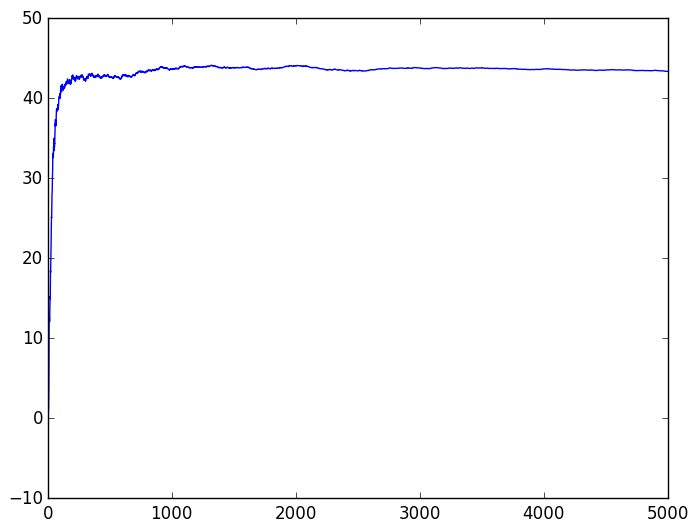

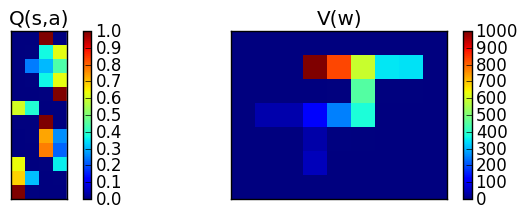

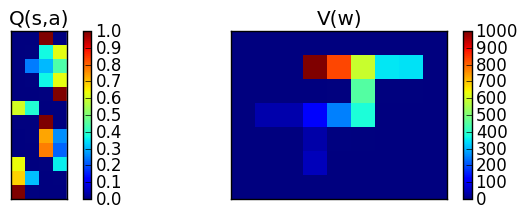

In [8]:
m4, v4 = run_experiment(4, 100, 5000, 100, 10)
plot(v4)
plot_data(m4[1])
writecsv("4.csv", v4)
f = open("4.dat", "w")
serialize(f, m4)
close(f)

Progress: 100% Time: 0:11:33


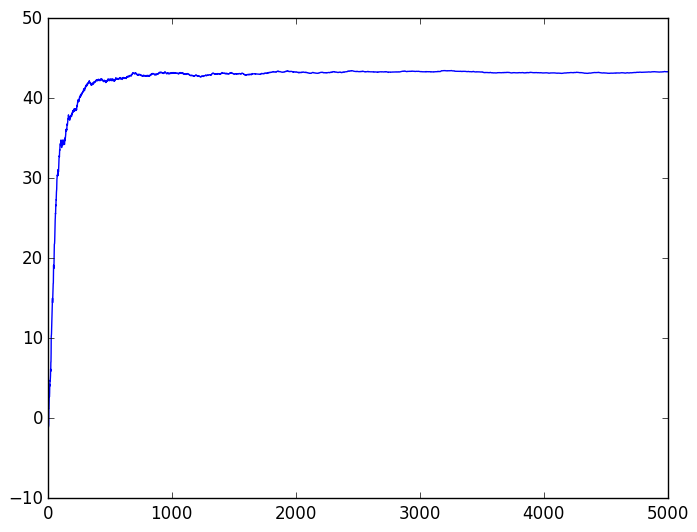

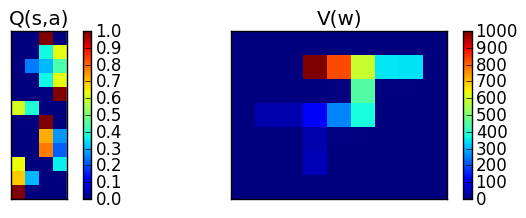

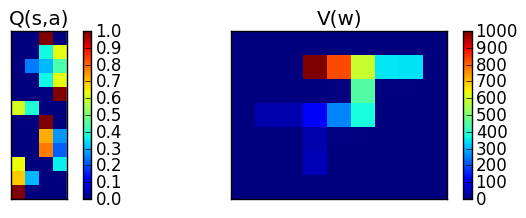

In [9]:
m3, v3 = run_experiment(3, 100, 5000, 100, 10)
plot(v3)
plot_data(m3[1])
writecsv("3.csv", v3)
f = open("3.dat", "w")
serialize(f, m3)
close(f)

Progress: 100% Time: 0:10:34


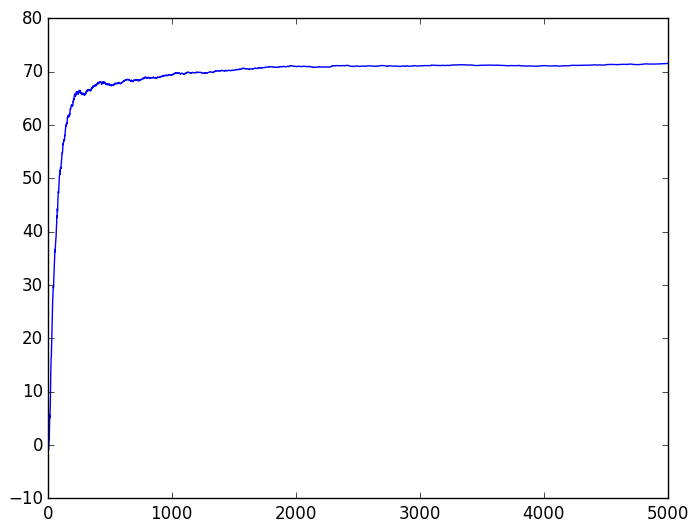

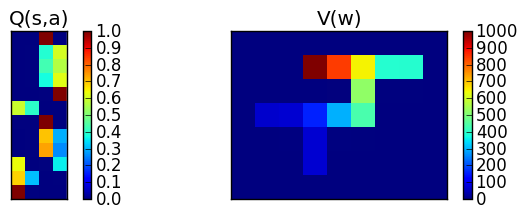

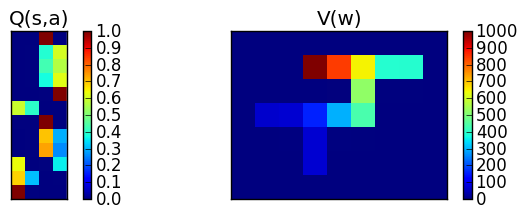

In [10]:
m2, v2 = run_experiment(2, 100, 5000, 100, 10)
plot(v2)
plot_data(m2[1])
writecsv("2.csv", v2)
f = open("2.dat", "w")
serialize(f, m2)
close(f)

Progress: 100% Time: 0:10:57


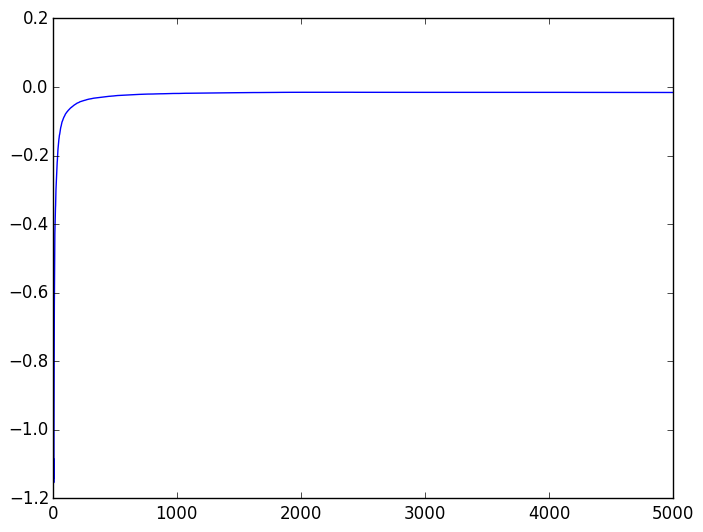

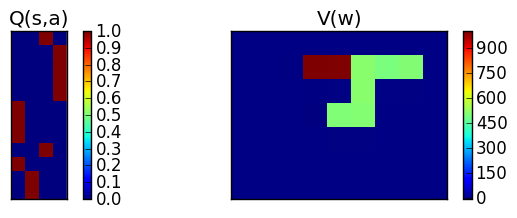

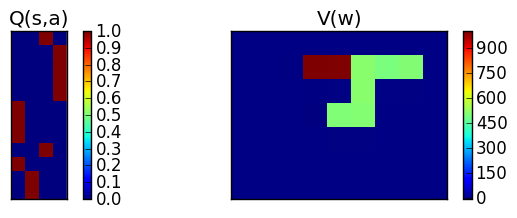

In [11]:
m1, v1 = run_experiment(1, 100, 5000, 100, 10)
plot(v1)
plot_data(m1[1])
writecsv("1.csv", v1)
f = open("1.dat", "w")
serialize(f, m1)
close(f)

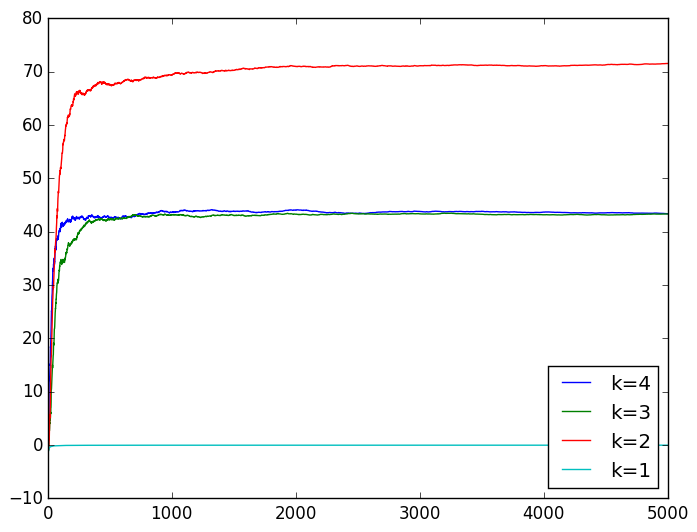

In [12]:
p4=plot(v4)
p3=plot(v3)
p2=plot(v2)
p1=plot(v1)
legend( [p4,p3,p2,p1], ["k=4","k=3","k=2","k=1"], loc=4)

savefig("plot.png")

Figure(PyObject <matplotlib.figure.Figure object at 0x134411850>)

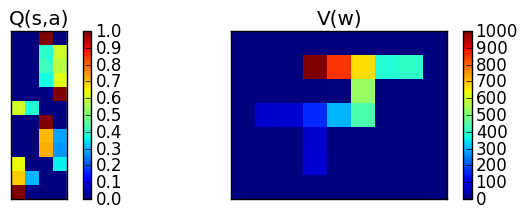

PyObject <matplotlib.text.Text object at 0x134e8e510>

In [31]:
plot_data(m2[25])

In [32]:
m2[25].Vw

7x9 Array{Float64,2}:
 0.0   0.0      0.0        0.0       0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0     1000.0     855.386  672.071  391.805  408.009  0.0
 0.0   0.0      0.0        0.0       0.0    531.474    0.0      0.0    0.0
 0.0  66.6028  70.9062   165.431   302.209  437.822    0.0      0.0    0.0
 0.0   0.0      0.0       69.2736    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0       72.8129    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0        0.0       0.0      0.0      0.0      0.0    0.0

Figure(PyObject <matplotlib.figure.Figure object at 0x11ae3f910>)

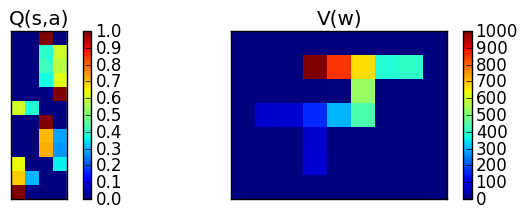

PyObject <matplotlib.text.Text object at 0x135182d10>

In [33]:
plot_data(m2[25])

In [22]:
m3[5].Vw

7x9 Array{Float64,2}:
 0.0   0.0      0.0        0.0       0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0     1000.0     835.591  598.365  348.904  358.261  0.0
 0.0   0.0      0.0        0.0       0.0    468.678    0.0      0.0    0.0
 0.0  43.5609  44.1113   111.442   243.802  384.786    0.0      0.0    0.0
 0.0   0.0      0.0       40.3769    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0       39.4891    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0        0.0       0.0      0.0      0.0      0.0    0.0